In [3]:
import os
import requests

In [4]:
DATA_DIR = "data"
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
URLS = {
    'KDDTrain+.txt':'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt',
    'KDDTest+.txt' : 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt'
}

def download_file(url,filename):
    local_path = os.path.join(DATA_DIR, filename)

    if os.path.exists(local_path):
        print(f"Correct file found: {filename} already exists")
        return
    print(f"Downloading {filename}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(local_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size = 8000):
                f.write(chunk)
        print(f"Success saved to {local_path}")
    except Exception as e:
        print(f"Failed to download {filename} :{e}")

In [5]:
for filename, url in URLS.items():
    download_file(url,filename)
print("\nAll files should now be in 'data' folder.")

Correct file found: KDDTrain+.txt already exists
Correct file found: KDDTest+.txt already exists

All files should now be in 'data' folder.


In [6]:
# Step:0 import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [10]:
import pandas as pd

#Step1:Load Provide Dataset, Column names from NSL-KDD (full list)
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
    'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
    'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
    'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
    'dst_host_srv_rerror_rate','attack_type','level'
]

train_path = os.path.join(DATA_DIR, 'KDDTrain+.txt')
test_path = os.path.join(DATA_DIR, 'KDDTest+.txt')

# Read CSV with our column names
train_df = pd.read_csv(train_path, names=columns)
test_df = pd.read_csv(test_path, names=columns)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()


Train shape: (125973, 43)
Test shape: (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [11]:
#Step 2:Slice Data(TCP Traffic,Normal/DOS) before tht we will check what are the unique attack types in the training data
attack_counts=train_df['attack_type'].value_counts()
print("Attack type counts:\n",attack_counts)

Attack type counts:
 attack_type
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64


In [12]:
#to make it easier of ML,we can create a new column attack_category
def categorize_attack(x):
    if x=='normal':
        return 'normal'
    elif x in['neptune','smurf','back','teardrop','pod','land']:
        return 'dos'
    elif x in ['satan','ipsweep','portsweep','nmap']:
        return 'probe' #scanning attacks
    elif x in ['guess_passwd','ftp_write','warezclient','warezmaster','phf','multihop','imap','spy','perl']:
        return 'r2l'  #Remote to Local
    elif x in ['buffer_overflow','loadmodule','rootkit']:
        return 'u2r' #User to Root
    else:
        return 'other'

train_df['attack_category'] = train_df['attack_type'].apply(categorize_attack)
test_df['attack_category'] = test_df['attack_type'].apply(categorize_attack)
print(train_df['attack_category'].value_counts())

attack_category
normal    67343
dos       45927
probe     11656
r2l         998
u2r          49
Name: count, dtype: int64


In [14]:
# Step 3: Keep only TCP traffic
tcp_train = train_df[train_df['protocol_type'] == 'tcp']
tcp_test = test_df[test_df['protocol_type'] == 'tcp']

# Step 4: Binary classification: normal vs DOS attacks
binary_train = tcp_train[tcp_train['attack_category'].isin(['normal','dos'])]
binary_test = tcp_test[tcp_test['attack_category'].isin(['normal','dos'])]

# Quick check
print("Binary Train shape:", binary_train.shape)
print(binary_train['attack_category'].value_counts())

print("Binary Test shape:", binary_test.shape)
print(binary_test['attack_category'].value_counts())


Binary Train shape: (95788, 44)
attack_category
normal    53600
dos       42188
Name: count, dtype: int64
Binary Test shape: (12865, 44)
attack_category
normal    7842
dos       5023
Name: count, dtype: int64


In [15]:
#should check balance or to check proportion on normal vs DOS
binary_train['attack_category'].value_counts(normalize=True)
#so abot 56% normal and 44% DOS-not heavily imbalanced,so Random Forest or similar classifiers will work well


attack_category
normal    0.559569
dos       0.440431
Name: proportion, dtype: float64

In [17]:
# Step 5: Aggregate / Roll-up by attack_category
agg_category = binary_train.groupby('attack_category')[['duration','src_bytes','dst_bytes']].mean()

print("\nAverage features per attack category:\n", agg_category)



Average features per attack category:
                   duration     src_bytes    dst_bytes
attack_category                                      
dos               0.006779   1216.122736   184.196051
normal           76.044813  16480.340672  5420.045802


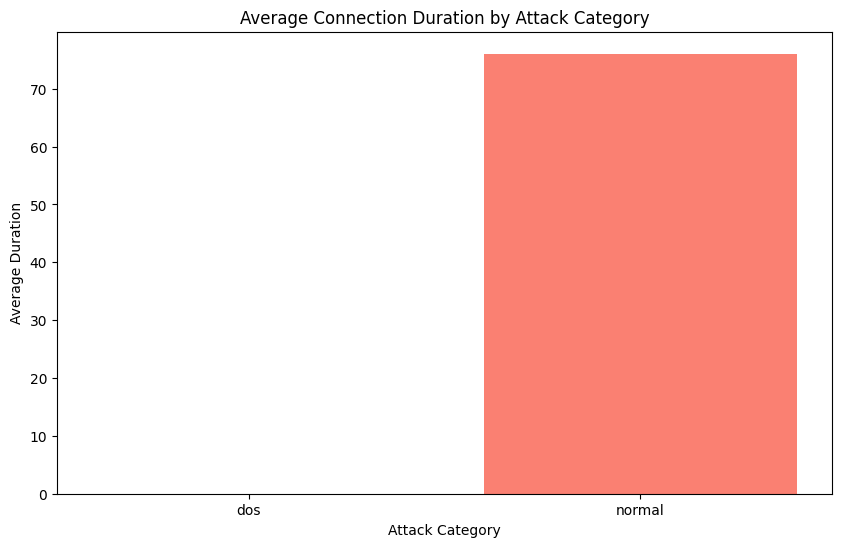

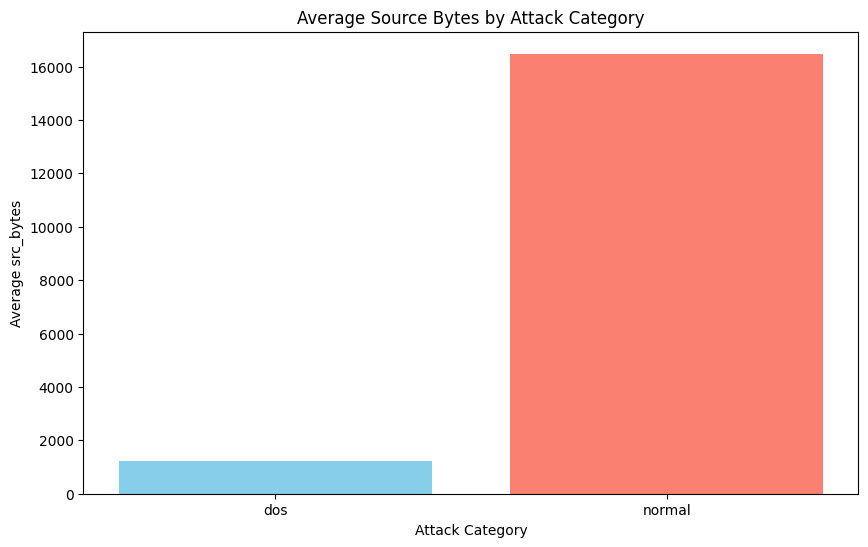

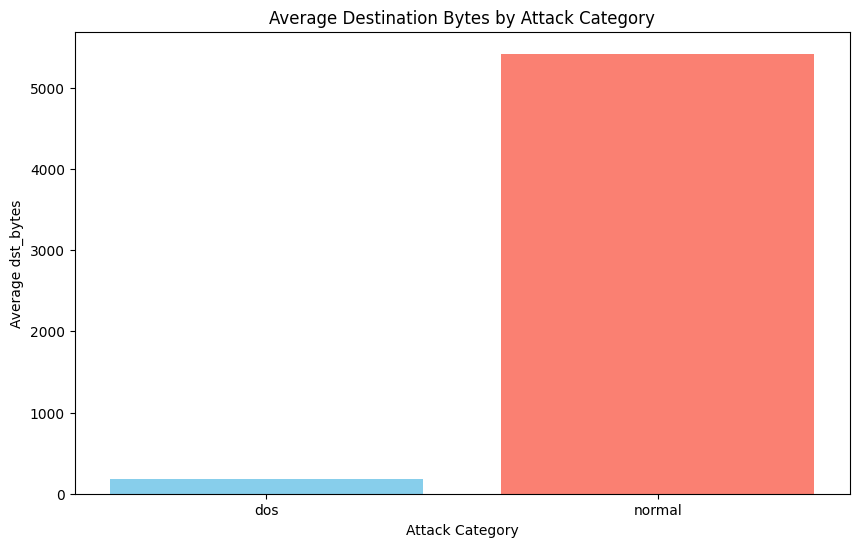

In [18]:
#Bar plot of Average features by Attack Category
import matplotlib.pyplot as plt

# Aggregate average features per attack category
agg_category = binary_train.groupby('attack_category')[['duration','src_bytes','dst_bytes']].mean()
agg_category = agg_category.reset_index()

# Plot
plt.figure(figsize=(10,6))

# Plot duration
plt.bar(agg_category['attack_category'], agg_category['duration'], color=['skyblue','salmon'])
plt.title("Average Connection Duration by Attack Category")
plt.xlabel("Attack Category")
plt.ylabel("Average Duration")
plt.show()

# Plot src_bytes
plt.figure(figsize=(10,6))
plt.bar(agg_category['attack_category'], agg_category['src_bytes'], color=['skyblue','salmon'])
plt.title("Average Source Bytes by Attack Category")
plt.xlabel("Attack Category")
plt.ylabel("Average src_bytes")
plt.show()

# Plot dst_bytes
plt.figure(figsize=(10,6))
plt.bar(agg_category['attack_category'], agg_category['dst_bytes'], color=['skyblue','salmon'])
plt.title("Average Destination Bytes by Attack Category")
plt.xlabel("Attack Category")
plt.ylabel("Average dst_bytes")
plt.show()


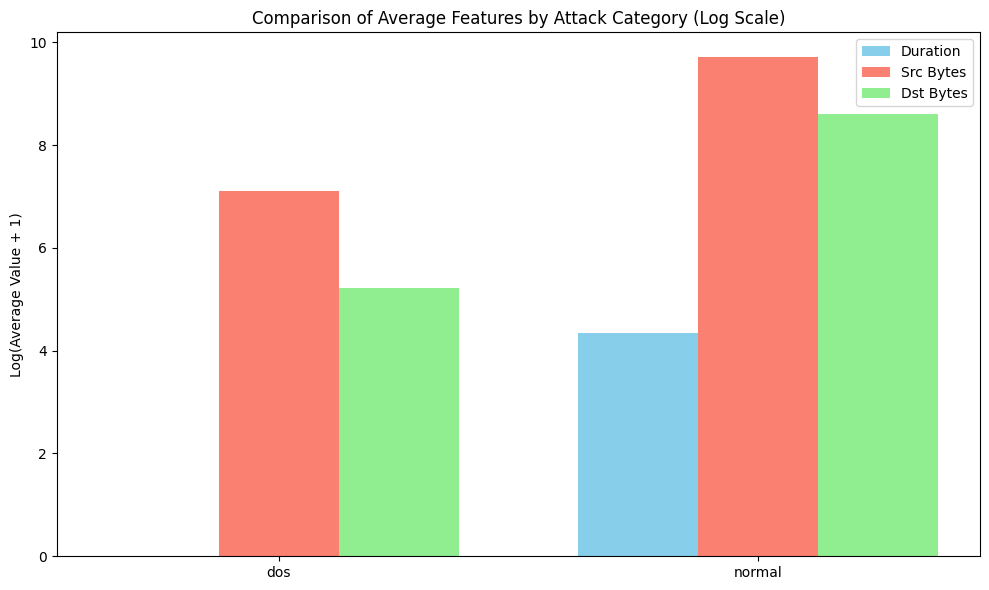

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Aggregate average features per attack category
agg_category = binary_train.groupby('attack_category')[['duration','src_bytes','dst_bytes']].mean()
agg_category = agg_category.reset_index()

# Apply log scale (log1p to handle zeros)
agg_category_log = agg_category.copy()
agg_category_log[['duration','src_bytes','dst_bytes']] = np.log1p(agg_category_log[['duration','src_bytes','dst_bytes']])

# Plot all three features in one grouped bar chart
features = ['duration','src_bytes','dst_bytes']
x = np.arange(len(agg_category_log['attack_category']))  # positions for attack categories
width = 0.25  # width of each bar

plt.figure(figsize=(10,6))

# Plot each feature
plt.bar(x - width, agg_category_log['duration'], width, label='Duration', color='skyblue')
plt.bar(x, agg_category_log['src_bytes'], width, label='Src Bytes', color='salmon')
plt.bar(x + width, agg_category_log['dst_bytes'], width, label='Dst Bytes', color='lightgreen')

# Labels and title
plt.xticks(x, agg_category_log['attack_category'])
plt.ylabel('Log(Average Value + 1)')
plt.title('Comparison of Average Features by Attack Category (Log Scale)')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Columns to encode
categorical_cols = ['protocol_type', 'service', 'flag']

categorical_cols = ['protocol_type', 'service', 'flag']

for col in categorical_cols:
    # Combine train + test to ensure all labels are captured
    combined = pd.concat([binary_train[col], binary_test[col]], axis=0)
    codes, uniques = pd.factorize(combined)
    
    # Split back into train and test
    binary_train[col] = codes[:len(binary_train)]
    binary_test[col] = codes[len(binary_train):]


# Columns to normalize
numeric_cols = ['duration', 'src_bytes', 'dst_bytes']

# StandardScaler for numerical features
scaler = StandardScaler()
binary_train[numeric_cols] = scaler.fit_transform(binary_train[numeric_cols])
binary_test[numeric_cols] = scaler.transform(binary_test[numeric_cols])

# Save the processed datasets for reuse
binary_train.to_csv('derived_train_attack_category.csv', index=False)
binary_test.to_csv('derived_test_attack_category.csv', index=False)

print("Preprocessing completed. Derived datasets saved!")
print("Binary Train shape:", binary_train.shape)
print("Binary Test shape:", binary_test.shape)


Preprocessing completed. Derived datasets saved!
Binary Train shape: (95788, 44)
Binary Test shape: (12865, 44)


Train shape: (95788, 44)
Test shape: (12865, 44)
Number of features: 41

Classification Report:

              precision    recall  f1-score   support

         dos       1.00      0.99      0.99      5023
      normal       0.99      1.00      1.00      7842

    accuracy                           1.00     12865
   macro avg       1.00      0.99      1.00     12865
weighted avg       1.00      1.00      1.00     12865



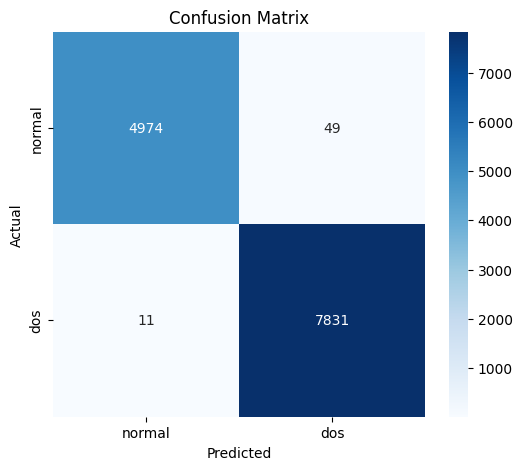

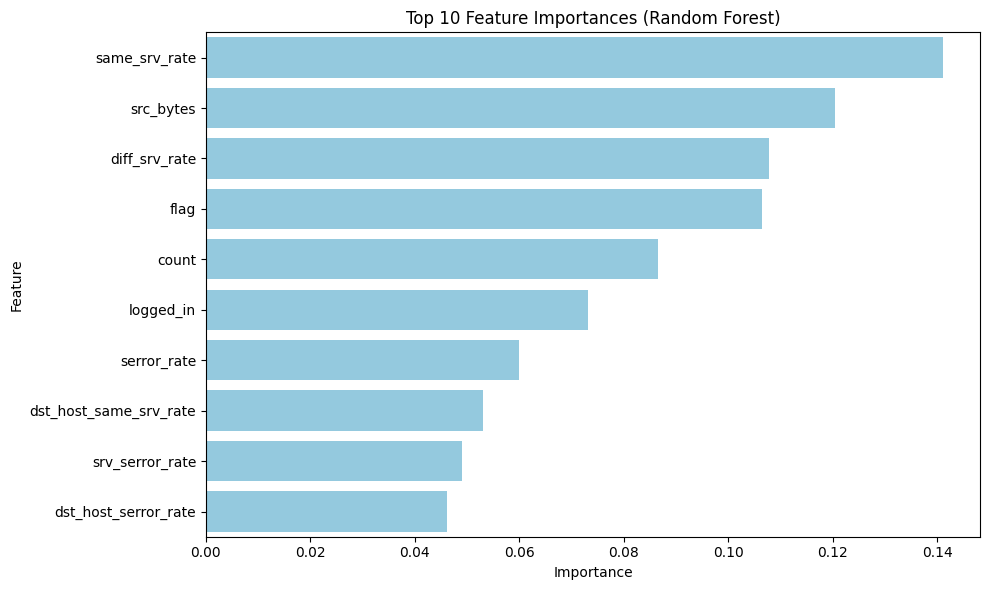

In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load preprocessed datasets
train_df = pd.read_csv('derived_train_attack_category.csv')
test_df = pd.read_csv('derived_test_attack_category.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Step 2: Prepare features and target
X_train = train_df.drop(['attack_type','attack_category','level'], axis=1)
y_train = train_df['attack_category']

X_test = test_df.drop(['attack_type','attack_category','level'], axis=1)
y_test = test_df['attack_category']

print("Number of features:", X_train.shape[1])

# Step 3: Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 4: Predict on Test Data
y_pred = model.predict(X_test)

# Step 5: Evaluate Model
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal','dos'], yticklabels=['normal','dos'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Step 6: Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

# Plot top 10 features with a single color (no palette, no warning)
sns.barplot(x=feat_importances, y=feat_importances.index, color='skyblue')

plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


